In [87]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [88]:
print("We're using TF", tf.__version__)
#print("We are using Keras", tf.keras.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

We're using TF 2.13.1
GPU 0: NVIDIA GeForce GTX 1080 (UUID: GPU-ea445096-085d-3bb5-1501-5923d113cbd5)
Wed Dec 13 23:31:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   23C    P8               6W / 210W |     19MiB /  8192MiB |      0%      Default |
|                                         |             

# MNIST

In [89]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


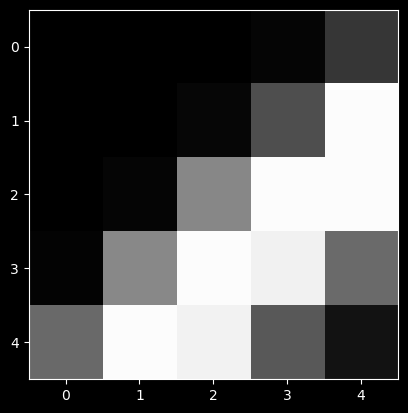

Пример картинки:


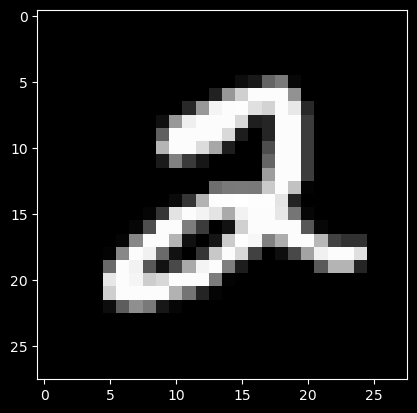

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [90]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

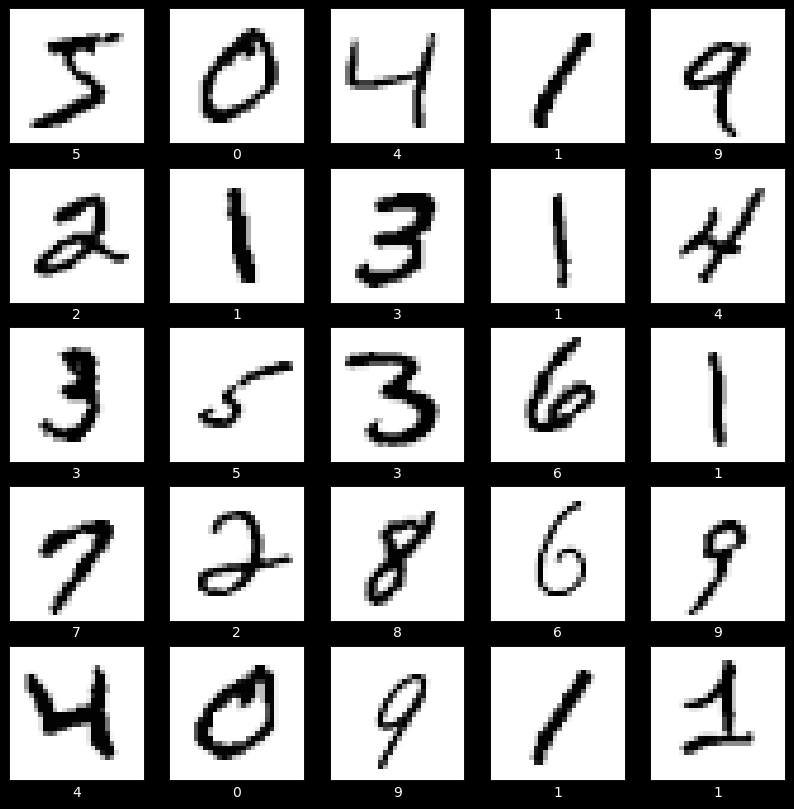

In [91]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

In [92]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)


# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

clear_session()

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)
(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


In [93]:
# Архитектура сети
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3341 - accuracy: 0.9010 - val_loss: 0.2193 - val_accuracy: 0.9311
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1602 - accuracy: 0.9513 - val_loss: 0.1147 - val_accuracy: 0.9628
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1166 - accuracy: 0.9636 - val_loss: 0.1313 - val_accuracy: 0.9570
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0956 - accuracy: 0.9707 - val_loss: 0.1009 - val_accuracy: 0.9675
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.9747 - val_loss: 0.0878 - val_accuracy: 0.9724
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0697 - accuracy: 0.9778 - val_loss: 0.0793 - val_accuracy: 0.9731
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0640 - accuracy: 0.9793 - val_loss: 0.0827 - val_accuracy: 0.9737
Epoch 

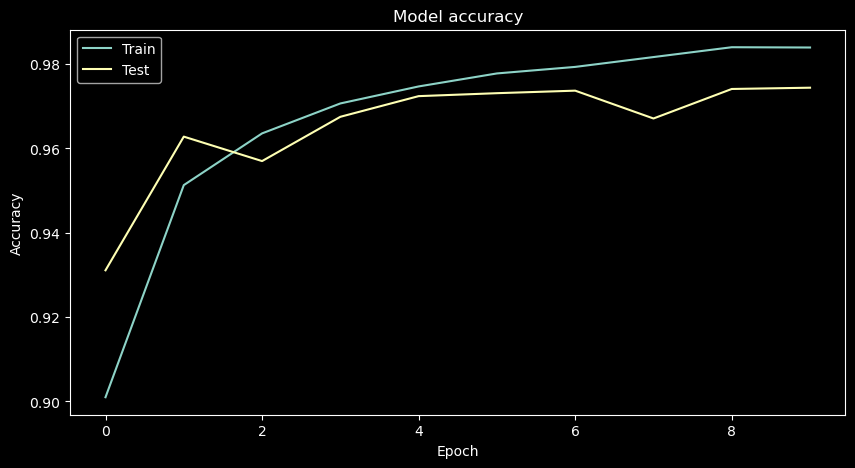

In [95]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

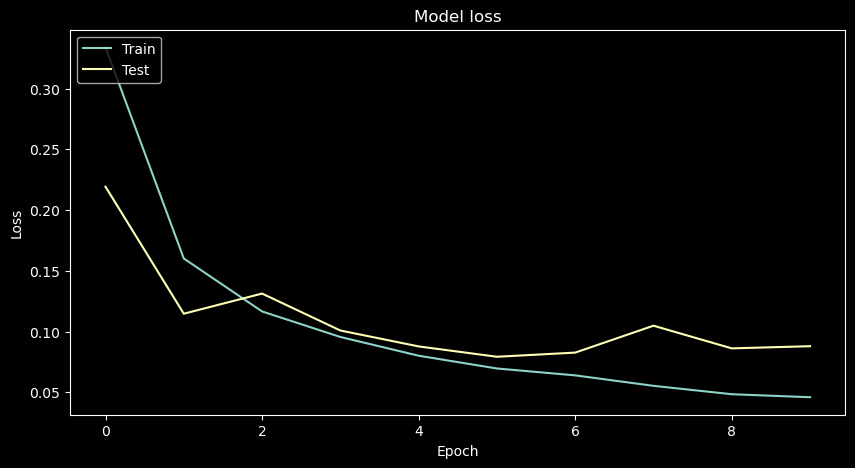

In [96]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [97]:
model.predict(x_val_float)

313/313 [==============================] - 0s 612us/step


array([[2.9232001e-07, 5.6928366e-07, 2.0849450e-07, ..., 9.9872679e-01,
        3.8448437e-08, 3.8597213e-05],
       [1.7240036e-09, 4.3224384e-07, 9.9999905e-01, ..., 1.0002019e-10,
        5.3236411e-09, 1.7120876e-18],
       [3.5477793e-08, 9.9994183e-01, 2.2491320e-05, ..., 2.5640935e-05,
        1.9694291e-06, 1.3916615e-08],
       ...,
       [6.1631666e-10, 3.7277157e-08, 1.1576281e-12, ..., 2.9614664e-06,
        1.9882389e-09, 1.4337422e-05],
       [3.9327039e-10, 6.3425599e-13, 2.1704186e-12, ..., 1.0210430e-09,
        2.3795835e-07, 2.6052413e-13],
       [2.3923259e-09, 2.0319856e-14, 6.9366951e-10, ..., 3.6399909e-14,
        3.6937184e-10, 2.0245196e-10]], dtype=float32)

In [98]:
#model.predict_classes(x_val_float)

# аналогично
#np.argmax(model.predict(x_val_float), axis = 1)

#predicts = model.predict_classes(x_val_float)
#print('Test Accuracy: ', accuracy_score(y_val, predicts))

In [99]:
predicts = model.predict(x_val_float) 
classes = np.argmax(predicts, axis=1)

print('Test Accuracy: ', accuracy_score(y_val, classes))

313/313 [==============================] - 0s 616us/step
Test Accuracy:  0.9744
